
[Github project link text](https://github.com/camygiuliani/giuliani-tesinaLabIA2023.git)

In particolare scaricate solo le zip sentinel2 e labels.
Se avete problemi a scaricare il dataset potete anche passare al DIAG e ve lo passo.
Vi allego train.txt e test.txt adattati con i nomi delle cartelle di sentinel2. Dovrete dividere train.txt in train.txt e val.txt in modo da avere anche il validation set. Potete ad esempio prendere le ultime 10 aree geografiche (6475_3361_13 - 8077_5007_13) del file come validation.

Per questo progetto vi chiedo di provare un diverso numero di bande in input:

    Le prime 4 -> sono quelle a più alta risoluzione (10m)
    Le prime 10 -> sono quelle a 10m + quelle a 20m di risoluzione
    Tutte e 12 -> 10m + 20m + 60m

Per aprire le immagini potete usare la libreria rasterio



Il modello che dovrete usare sarà U-Net.

Createvi innanzitutto la classe del vostro dataset e visualizzate l'output del dataloader.
Normalizzate il dataset usando la media e la deviazione std (per ogni banda) del train set.
Preparate il modello e trainate una baseline.
Usate IoU per ogni classe e mean IoU come metriche.
Per migliorare le prestazioni potete provare ad esempio:

    Bilanciare la loss passando il parametro weight alla loss (il parametro lo scegliete in base al numero di pixel di ogni classe nel train set)
    https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    Usare data augmentation (attenzione ad usare la stessa augmentation sia per l'immagine che per la label).

Createvi delle funzioni per visualizzare i risultati.
Salvatevi i checkpoint ogni epoca perché a volte Colab vi
 disconnette prima che il train sia finito e dovrete ricominciare dall'ultimo checkpoint.
Infine preparate un github con il codice/risultati.


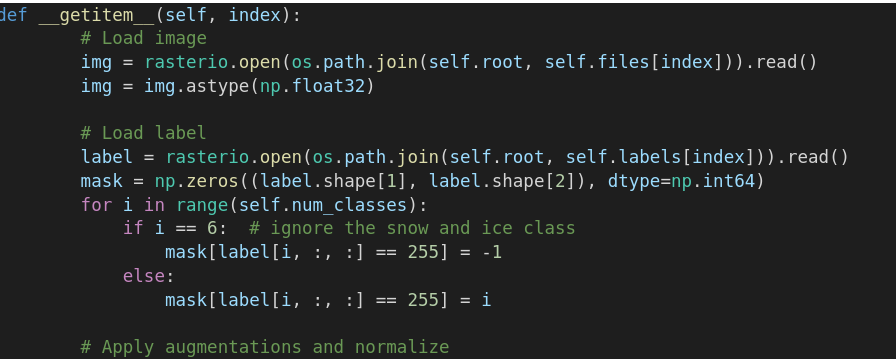

## Iniziamo

Questo è il mio progetto che ha come protagonista la Semantic Segmentation e la change detection.

##Che cosa vogliamo fare?
Si tratta di un problema di classificazione.Abbiamo a disposizione il dataset Sentinel2 con immagini satellitari , il nostro scopo sarà quello di classificare ogni pixel in base a 7 classi.

Importiamo le librerie e i moduli necessari.

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm import tqdm
import time
!pip install albumentations
import albumentations as A
!pip install  segmentation_models_pytorch
import segmentation_models_pytorch as smp
import pandas as pd
from torch.utils.data import Dataset

!pip install rasterio
import rasterio
from rasterio.plot import show

torch.manual_seed(42) # Setting the seed
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
## colleghiamo con google dirve
from google.colab import drive
drive.mount('/content/drive')



Device cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
## TUTTE LE COSTANTI
EPOCHS= 200
ROOT= "/content/drive/MyDrive/Lab_IA"
CLASS_LABELS={ 0: "impervious serface",
               1: "agriculture",
               2: "forest & other vegetation",
               3: "wetlands",
               4: "soil",
               5: "water",
               6:"snow & ice"}
CHECKPOINT_DIR='/content/drive/MyDrive/Lab_IA/checkpoints'
NUM_WORKERS=4
NUM_CLASSES=6
MEAN=[1172.19328983 ,1400.06327287 ,1446.52633482 ,2774.75166992 ,1809.95593384,
 2473.51136111, 2725.8684945 , 2884.20716899 ,2351.73818368 ,1751.09612993,
 1086.05440252 ,3114.15244344]
STD=[1589.62818241 ,1510.50277198 ,1574.79573854 ,1415.32693599 ,1556.10662877,
 1408.36338065, 1412.76236733 ,1404.81120492 ,1380.26829348 ,1306.86991945,
 1648.63427304 ,2026.37363878]



Implementiamo la classe per il nostro dataset.

Come metriche utilizziamo

>IoU: The ratio between the intersection and the union of the predicted
segmentation and the ground truth.E'anche famosa come Jaccard Index,la usiamo per valutare l'accuratezza della sovrapposizione tra maschere predette e maschere di groud-truth


> mIoU: The mean of the IoU values across all the classes

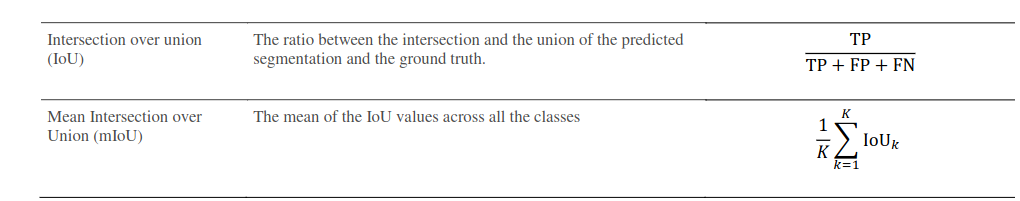







In [3]:

## Funzioni per data augmentation
def get_train_augmentations():
      '''
      '''
      transforms=[]
      transforms.extend([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.RandomRotate90(p=1.0),
      ])

      return A.Compose(transforms)

def get_test_augmentations():
      transforms=[]

      '''
      '''

      return A.Compose(transforms)


In [22]:
class MyDynamicEarthNet(Dataset):
    def __init__(self, root, mode, mean=np.zeros((12,)),std=np.zeros((12,)),num_classi=6 ):
        """
        Args:
            root: the root of the folder which contains planet imagery and labels
            mode: train/val/test -- selects the splits

            reference_date: for positional encoding defaults:2018-01-01
            crop_size: crop size default:1024x1024
            num_classes: for DynamicEarthNet numclasses: 6

        """
        self.root = root
        self.mode = mode

        self.num_classi = num_classi
        self.mean=mean
        self.std=std
        self.normalize = None

        '''
        if(mode=="train"):
          if files_train!=None and labels_train!=None:
                self.files=files_train
                self.labels=labels_train

          else:
        '''
        self.files,self.labels= self.get_file_labels(mode)



        if(mode=="train"):
          self.augmentations= get_train_augmentations()
          ##media e deviazione standard le calcolo sul training set
          if MEAN != None and STD !=None:
            self.mean=MEAN
            self.std=STD
            self.normalize = transforms.Normalize(mean=self.mean, std=self.std)
          else:
            self.calculate_mean_std()
        else:
          self.augmentations= get_test_augmentations()






    def get_file_labels(self,mode):

      with open(os.path.join(self.root,self.mode+".txt"),"r") as f:
        nonfile=[]
        nonlabel=[]
        lista_file=[]
        for line in tqdm(f):
          line=line.rstrip().split(' ')
          file_path=line[0]
          label_path=line[1]
          nome_file=file_path.split("/")[2]
          nome_file=nome_file.split("-")[0]+"_"+nome_file.split("-")[1]+".tif"
          file_path=file_path.split("/")[0]+"/"+file_path.split("/")[1]+"/"+nome_file
          if  os.path.exists(os.path.join(ROOT,file_path))==False or os.path.exists(os.path.join(ROOT,label_path))==False:
              if os.path.exists(os.path.join(ROOT,file_path))==False:
                  nonfile.append(os.path.join(ROOT,file_path))
                  print("Non trovato file path ", os.path.join(ROOT,file_path))
              if os.path.exists(os.path.join(ROOT,label_path))==False:
                nonlabel.append(os.path.join(ROOT,label_path))
                print("Non trovato label path ", os.path.join(ROOT,label_path))



          #print("File path:",file_path,"\n e label_path:",label_path,"\n")
          else:
            lista_file.append((file_path,label_path))
        self.files,self.labels=list(zip(*lista_file))

      #print("sto per calcolare la media e std")
      #self.mean,self.std= self.calculate_mean_std()
      print("\n\nLe liste self.files e self.labels sono pronte\n")
      print(f"Il {mode} set contiene {len(self.files)} elementi")
      return self.files, self.labels


    '''
    def set_files(self):
        self.file_list = os.path.join(self.root, "dynnet_training_splits", f"{self.mode}" + ".txt")
        print (self.file_list)
        file_list = [line.rstrip().split(' ') for line in tuple(open(self.file_list, "r"))]
        self.files, self.labels, self.year_months = list(zip(*file_list))

        if self.type == 'daily':
            self.all_days = list(range(len(self.files)))

            for i in range(len(self.files)):
                self.planet, self.day = [], []
                date_count = 0
                for _, _, infiles in os.walk(os.path.join(self.root, self.files[i][1:])):
                    for infile in sorted(infiles):
                        if infile.startswith(self.year_months[i]):
                            self.planet.append(os.path.join(self.files[i], infile))
                            self.day.append((datetime(int(str(infile.split('.')[0])[:4]), int(str(infile.split('.')[0][5:7])),
                                                  int(str(infile.split('.')[0])[8:])) - self.reference_date).days)
                            date_count += 1
                self.all_days[i] = list(zip(self.planet, self.day))
                self.all_days[i].insert(0, date_count)

        else:
            self.planet, self.day = [], []
            if self.type == 'weekly':
                self.dates = ['01', '05', '10', '15', '20', '25']
            elif self.type == 'single':
                self.dates = ['01']

            for i, year_month in enumerate(self.year_months):
                for date in self.dates:
                    curr_date = year_month + '-' + date
                    self.planet.append(os.path.join(self.files[i], curr_date + '.tif'))
                    self.day.append((dat1589.62818241 1510.50277198 1574.79573854 1415.32693599 1556.10662877
 1408.36338065 1412.76236733 1404.81120492 1380.26829348 1306.86991945
 1648.63427304 2026.37363878etime(int(str(curr_date)[:4]), int(str(curr_date[5:7])),
                                                  int(str(curr_date)[8:])) - self.reference_date).days)
            self.planet_day = list(zip(*[iter(self.planet)] * len(self.dates), *[iter(self.day)] * len(self.dates)))


    def load_data(self, index):
        cur_images= []
        for i in range(len(self.files)):
            # read .tif
             img = rasterio.open(os.path.join(self.root, self.files[i]))
              #red = img.read(3)
            #green = img.read(2)
            #blue = img.read(1)
            #nir = img.read(4)
             image = np.dstack((img.read[0],img.read[1],img.read[2],img.read[3],img.read[4],img.read[5],img.read[6],
                                   img.read[6],img.read[7],img.read[8],img.read[9],img.read[10],img.read[11]))
             cur_images.append(np.expand_dims(np.asarray(image, dtype=np.float32), axis=0))   # np.array already\

        image_stack = np.concatenate(cur_images, axis=0)
        label = rasterio.open(os.path.join(self.root, self.labels[index]))
        label = label.read()
        mask = np.zeros((label.shape[1], label.shape[2]), dtype=np.int32)

        for i in range(self.num_classi):
            if i == 6:
                    mask[label[i, :, :] == 255] = -1
            else:
                    mask[label[i, :, :] == 255] = i

        return (image_stack, mask)
  '''

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        ##immagine cercata
        imm= rasterio.open(os.path.join(self.root,self.files[index])).read()

        ##il formato giusto è float32
        imm=imm.astype(np.float32)

        ##carico anche l'etichetta
        label= rasterio.open(os.path.join(self.root,self.labels[index])).read()
        ##maschera per la classe
        mask=np.zeros((label.shape[1],label.shape[2]),dtype=np.int64)     ## label.shape[1] la larghezza e label.shape [2] per altezza
        for i in tqdm(range(self.num_classi+1)):
          ## non considero la classe 6 corrispondente a snow and ice
          if i==6:
            mask[label[i,:,:]==255]=-1
          else:
            mask[label[i,:,:]==255]=i

        ## è il momento di normalizzare e fare data augmentation
        imm_trasp=imm.transpose(1,2,0)
        augm= self.augmentations(image=imm_trasp,mask=mask)
        ##transformo in tensore
        img= torch.from_numpy(augm["image"].transpose(2,0,1))
        #img=img.to(device)

        #normalizzo
        img=self.normalize(img)


        return (img, mask)



    def calculate_mean_std(self):
      # Mean
      print("Sto calcolando la media")

      nontrovati=[]

      sum= np.zeros((12,))
      sum=sum.astype(np.float64)
      num_pixel=0
      i=0
      for im in tqdm(self.files):
        im_path= os.path.join(self.root,im)
        if os.path.exists(im_path)==False:
          nontrovati.append(im_path)
          #print("\nPath ",im_path,"  non trovato,lo salto :( ")
          continue
        src= rasterio.open(im_path)
        img=src.read()
        if(i==0):
          #print("\nimg ha shape: ",img.shape,"\n")
          i+=1
        sum += np.sum(img,axis=(1,2))
        num_pixel+=img.shape[1]* img.shape[2]

      mean=  sum/num_pixel


      ## Deviazione standard
      print("Ora calcolo la deviazione standard")
      sum= np.zeros((12,))
      sum=sum.astype(np.float64)

      for im in tqdm(self.files):

        im_path= os.path.join(self.root,im)
        if os.path.exists(im_path)==False:
          #print("\nPath ",im_path,"  non trovato,lo salto :( ")
          continue
        src= rasterio.open(im_path)
        img=src.read()
        sum += np.sum((img-mean.reshape(12,1,1))**2,axis=(1,2))

      std=  np.sqrt(sum/num_pixel)
      STD=std
      self.std=std
      MEAN=mean
      self.mean=mean
      print(f"Mean:{self.mean}")

      print(f"Std:{self.std}")
      self.normalize = transforms.Normalize(mean=self.mean, std=self.std)

      print("Path non trovati...\n",nontrovati)



In [23]:
##creazione training set
training_set= MyDynamicEarthNet(root=ROOT ,mode='train')


1050it [00:00, 2984.17it/s]



Le liste self.files e self.labels sono pronte

Il train set contiene 1050 elementi


In [24]:
#validation set
validation_set=MyDynamicEarthNet(root=ROOT,mode="val")

118it [00:00, 3329.13it/s]



Le liste self.files e self.labels sono pronte

Il val set contiene 118 elementi


In [25]:
# test set
test_set=MyDynamicEarthNet(root=ROOT,mode="test")

120it [00:00, 3614.07it/s]



Le liste self.files e self.labels sono pronte

Il test set contiene 120 elementi


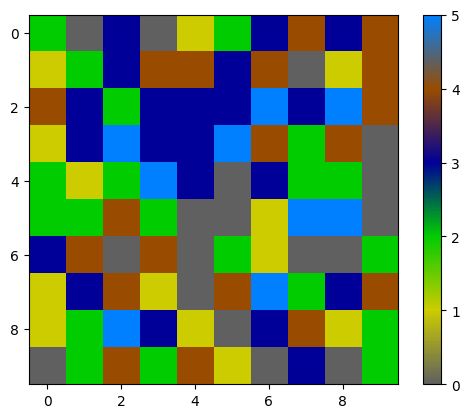

In [11]:

from matplotlib.colors import LinearSegmentedColormap

def create_custom_cmap():
    """
    Crea una mappa dei colori personalizzata (cmap) utilizzando i colori specificati.

    Ritorna:
    cmap -- la mappa dei colori personalizzata
    """
    cmap = np.zeros((6, 3), dtype=np.uint8)

    cmap[0] = np.array([96, 96, 96])  # impervious surface
    cmap[1] = np.array([204, 204, 0])  # agriculture
    cmap[2] = np.array([0, 204, 0])  # forest & other
    cmap[3] = np.array([0, 0, 153])  # wetland
    cmap[4] = np.array([153, 76, 0])  # soil
    cmap[5] = np.array([0, 128, 255])  # water

    # Normalizza i colori tra 0 e 1
    normalized_colors = cmap / 255.0

    # Crea una lista di punti per la mappa dei colori
    points = np.linspace(0, 1, len(normalized_colors))

    # Crea il dizionario dei segmenti di colore per la mappa dei colori
    color_segments = {'red': [], 'green': [], 'blue': []}
    for i, color in enumerate(normalized_colors):
        color_segments['red'].append((points[i], color[0], color[0]))
        color_segments['green'].append((points[i], color[1], color[1]))
        color_segments['blue'].append((points[i], color[2], color[2]))

    # Crea la mappa dei colori personalizzata
    cmap = LinearSegmentedColormap('custom_cmap', color_segments)

    return cmap

# Esempio di utilizzo
custom_cmap = create_custom_cmap()

# Esempio di applicazione della mappa dei colori a un grafico
data = np.random.randint(0, 6, size=(10, 10))  # Dati di esempio
plt.imshow(data, cmap=custom_cmap)
plt.colorbar()
plt.show()


100%|██████████| 7/7 [00:00<00:00, 892.62it/s]


Analizziamo l'immagine num  901


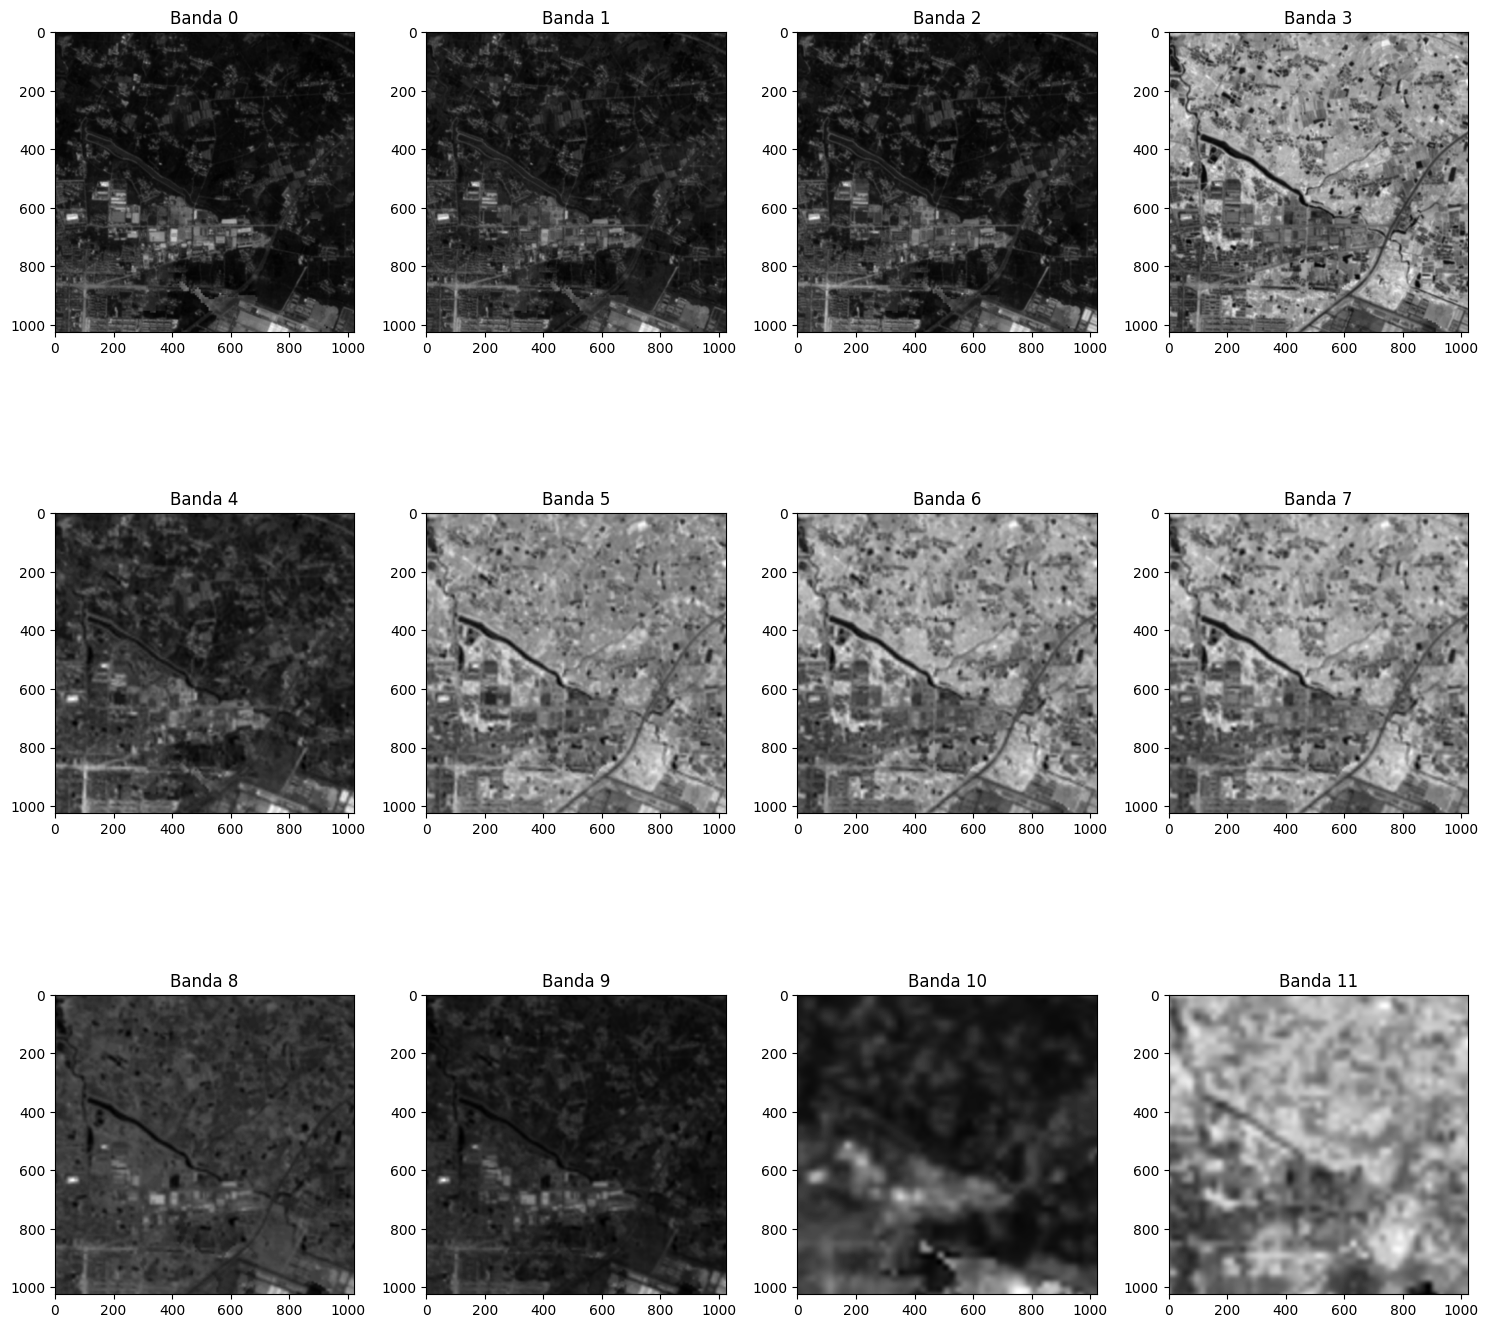

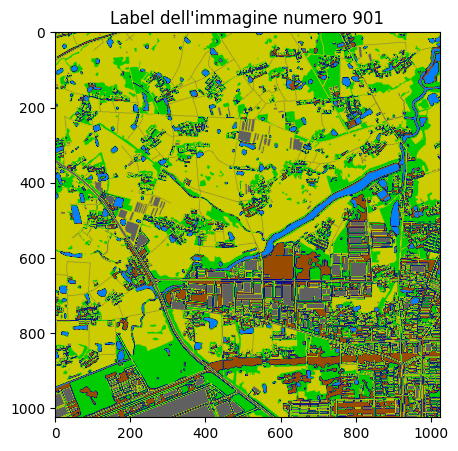

In [26]:
## proviamo a visualizzare tutti i canali di una specifica immagine .tif
index_pic=901
image,mask=training_set.__getitem__(index_pic)
image=image.to(device)


# show the enhanced image
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 15))
print("Analizziamo l'immagine num ",index_pic)
image=image.permute(1,2,0)
a=0
b=0
for i in range(image.shape[2]):
  axs[a,b].imshow(image[:,:,i].cpu(),cmap='gray')
  axs[a,b].set_title(f"Banda {i}")
  b+=1
  if i!=0 and b==4:
    a+=1
    b=0
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

axs.imshow(mask,cmap=custom_cmap)
axs.set_title(f"Label dell'immagine numero {index_pic}")
plt.show()

In [ ]:
def recursive_todevice(self, x):
        if isinstance(x, torch.Tensor):
            return x.to(self.device)
        elif isinstance(x, dict):
            return {k: self.recursive_todevice(v) for k, v in x.items()}
        else:
            return [self.recursive_todevice(c) for c in x]## prova dataloader

print(len(train_loader))
for batch_indx, (image,mask) in enumerate(train_loader):
  print("Batch#",batch_indx,"\n")
  image=image.to(device)
  print(image.shape)


1056


100%|██████████| 7/7 [00:00<00:00, 1171.64it/s]


Batch# 0 

torch.Size([1, 12, 1024, 1024])
Batch# 1 

torch.Size([1, 12, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1613.90it/s]


Batch# 2 

torch.Size([1, 12, 1024, 1024])
Batch# 3 

torch.Size([1, 12, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1691.35it/s]


Batch# 4 

torch.Size([1, 12, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1152.55it/s]


Batch# 5 

torch.Size([1, 12, 1024, 1024])
Batch# 6 

torch.Size([1, 12, 1024, 1024])
Batch# 7 

torch.Size([1, 12, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 908.31it/s]


Batch# 8 

torch.Size([1, 12, 1024, 1024])
Batch# 9 

torch.Size([1, 12, 1024, 1024])
Batch# 10 

torch.Size([1, 12, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1019.87it/s]


Batch# 11 

torch.Size([1, 12, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 941.06it/s]


Batch# 12 

torch.Size([1, 12, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1044.47it/s]


Batch# 13 

torch.Size([1, 12, 1024, 1024])
Batch# 14 

torch.Size([1, 12, 1024, 1024])
Batch# 15 

torch.Size([1, 12, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1606.22it/s]


Batch# 16 

torch.Size([1, 12, 1024, 1024])
Batch# 17 

torch.Size([1, 12, 1024, 1024])
Batch# 18 

torch.Size([1, 12, 1024, 1024])
Batch# 19 

torch.Size([1, 12, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 920.96it/s]


Batch# 20 

torch.Size([1, 12, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1539.44it/s]


Batch# 21 

torch.Size([1, 12, 1024, 1024])
Batch# 22 

torch.Size([1, 12, 1024, 1024])
Batch# 23 

torch.Size([1, 12, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 848.46it/s]


Batch# 24 

torch.Size([1, 12, 1024, 1024])


RasterioIOError: ignored

100%|██████████| 7/7 [00:00<00:00, 1266.18it/s]


#UNet
Implementiamo adesso la rete UNet che è una fully-convolutional-network

First path is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions. Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.

In [32]:
n_channels=12
class UNet(nn.Module):
  def __init__(self):
    super(UNet,self).__init__()
    in_ch=12
    self.model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                                in_channels=3, out_channels=1, init_features=32, pretrained=False)
    self.model.encoder1.enc1conv1=nn.Conv2d(in_ch,32, kernel_size=(3,3),stride=(1,1),padding=(1,1),bias=False)
    self.model.conv=nn.Conv2d(32,6,kernel_size=(1,1),stride=(1,1))

  def forward(self,x):
      return self.model(x)



##testing my unet
model=UNet()
print(model)


'''
    self.model.encoder.conv1=nn.Conv2d(n_channels,out_channels=32,kernel_size=(3,3),stride=(1,1),padding=(1,1),bias=False)
    self.model.segmentation_head[0]=nn.Conv2d(16,6,kernel_size=(1,1),stride=(1,1))

  def forward(self,x):
    return self.model(x)

##testing my unet
model=UNet().to(device)
print(model)
'''

UNet(
  (model): UNet(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm2): BatchNorm

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


'\n    self.model.encoder.conv1=nn.Conv2d(n_channels,out_channels=32,kernel_size=(3,3),stride=(1,1),padding=(1,1),bias=False)\n    self.model.segmentation_head[0]=nn.Conv2d(16,6,kernel_size=(1,1),stride=(1,1))\n\n  def forward(self,x):\n    return self.model(x)\n\n##testing my unet\nmodel=UNet().to(device)\nprint(model)\n'

In [42]:
# Crea il DataLoader utilizzando il dataset
train_loader= DataLoader(training_set, batch_size=10, shuffle=True, num_workers=4,pin_memory=False)
val_loader= DataLoader(validation_set,batch_size=10, shuffle=False, num_workers=4,pin_memory=False)
test_loader=DataLoader(test_set,batch_size=10, shuffle=False, num_workers=4,pin_memory=False)

In [ ]:
#The optimizer (SGD) and the criterian for crossentropy
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)# insert optimizer instantiation
criterion =  torch.nn.CrossEntropyLoss().to(device)# insert loss instantiation
print(model)

UNet(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm

In [34]:
class TopKCrossEntropy(torch.nn.Module):
    """This class conmputes the top-k cross-entropy loss."""
    def __init__(self, k=1.0, ignore_index=-100):
        super(TopKCrossEntropy, self).__init__()
        self.ignore_index = ignore_index
        self.k = k

    def forward(self, input, target):
        loss = F.cross_entropy(input, target, weight=None,
                               ignore_index=self.ignore_index, reduction='none')
        if self.k == 1.0:
            return torch.mean(loss)
        else:
            loss = torch.flatten(loss, start_dim=1)
            valid_loss, _ = torch.topk(loss, int(self.k * loss.size()[1]))
            return torch.mean(valid_loss)

In [43]:
from argparse import Namespace
class WrapperUNet:
  def __init__(self,net,iter_per_epoch):
    self.net=net
    self.best_acc = 0.0
    self.iter_per_epochs=iter_per_epoch
    self.num_classes= NUM_CLASSES
    self.lr=0.0001
    self.weight_penalty=0
    self.set_optimizer()
    self.loss= TopKCrossEntropy(ignore_index=-1)



  def set_optimizer(self):
    self.optimizer=torch.optim.Adam(self.net.parameters(), lr=self.lr, weight_decay=self.weight_penalty)
    return


  def optim_step_(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


  def train_epoch(self,epoch,data_loader):
    self.net.train()
    epoch_loss=[]
    for batch_size,(image,mask) in enumerate(data_loader):
            print(">>Batch numero #",batch_size)
            #image=image.to(device)
            #image= image.squeeze(dim=0)

            mask = mask.long()
            print("mask ha shape",len(mask))
            #mask=mask.to(device)
            pred = self.net(image)
            print("pred ha shape",pred.shape)
            #for i in range(pred.shape[0]):
            #  plt.imshow(pred.squeeze(dim=0).detach().numpy().transpose(1,2,0)[:,:,i],cmap=custom_cmap)
            #  plt.show()
            print("La mask era")
            #plt.imshow(mask.permute(1,2,0),cmap=custom_cmap)
            #plt.show()
            loss = self.loss(pred,mask)
            self.optim_step_(loss)
            epoch_loss.append(loss.item())
            if (i+1) % 50 == 0 or (i+1) == len(data_loader):
               print('Batch:{} TRAIN loss={:.3f}'.format(i + 1, np.mean(epoch_loss)))
        #if self.lr_scheduler:
        #    self.lr_scheduler.step()


  def evaluate_model(self,epoch,data_loader):
    """ Le metriche che utilizzo sono IoU e mIoU
    """
    self.net.eval()
    pred = self.net.forward(image)
    epoch_val_loss = []
    total_correct, total_label = 0, 0
    total_inter, total_union = 0, 0
    pixAcc=0.0
    with torch.no_grad():
            for i, data in enumerate(data_loader):
                (image,dates), mask = self.recursive_todevice(data)
                mask = mask.long()
                pred = self.net.forward(image, batch_positions=dates)
                val_loss = self.semantic_seg_loss(pred, mask)
                epoch_val_loss.append(val_loss.item())
                correct, labeled, inter, union = get_metrics(pred, mask, NUM_CLASSES, self.config['DATA']['IGNORE_INDEX'])
                total_inter, total_union = total_inter + inter, total_union + union
                total_correct, total_label = total_correct + correct, total_label + labeled


                pixAcc = 1.0 * total_correct / (np.spacing(1) + total_label)



    metrics= Namespace(pixAcc=pixAcc, mIoU=mIoU,IoU=IoU)#, c=seg_metrics["Class_IoU"])
    return metrics




  def checkp_saving(self,epoch,out_dir,last_ckpt=False,best_acc=None,is_best=False):
    ckpt = {'last_epoch': epoch, 'best_acc': best_acc, 'model_dict': self.net.state_dict(),
                'optimizer_dict': self.optimizer.state_dict(),
                }
    if last_ckpt:
       ckpt_name = 'last_ckpt.pth'
    elif is_best:
       ckpt_name = 'best_ckpt.pth'
    else:
       ckpt_name = 'ckpt_ep{}.pth'.format(epoch + 1)
    ckpt_path = os.path.join(out_dir, ckpt_name)
    torch.save(ckpt, ckpt_path)


  def load_checkpoint(self,C):
    pass

  def print_net_(self):
        for k, v in self.net.state_dict().items():
            print(k, v.size())


In [ ]:

iter_per_epoch = len(train_loader)
wrapper = WrapperUNet(model, iter_per_epoch)
best_acc = wrapper.best_acc

print("Starting epochs now...")
for epoch in tqdm(range(EPOCHS)):
  start_time=time.time()
  print(f"\nNum epoch {epoch}")
  wrapper.train_epoch(epoch,train_loader)
  wrapper.checkp_saving(epoch,CHECKPOINT_DIR,best_acc=best_acc,last_ckpt=True)

  ## evaluation su validation set
  metrics=wrapper.evaluate_model(epoch,val_loader)
  print(f"Evaluation epoch {epoch},IoU:{metrics.IoU} meanIoU:{metrics.mIoU}")


  ## save best model

  mean_iou = metrics.mIoU

  if mean_iou > best_acc:
        best_acc = mean_iou
        wrapper.checkpt_saving(epoch, CHECKPOINT_DIR, best_acc=best_acc, is_best=True)
        print(f'>>Save best model: epoch={epoch} best_iou:{mean_iou}')

  ## statistics
  end_time=time.time()
  print(f"Time epoch {epoch}: {end_time-start_time}")


In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
for batch_size , (image,mask) in enumerate(train_loader):
  print("nel for",type(images))
  print("Batch number",batch_size)
  print(images.shape)
  print(mask.shape)


100%|██████████| 7/7 [00:00<00:00, 1426.70it/s]


<class 'torch.Tensor'>
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1128.71it/s]


nel for <class 'torch.Tensor'>
Batch number 0
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 811.73it/s]


nel for <class 'torch.Tensor'>
Batch number 1
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 2
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 3
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1394.78it/s]


nel for <class 'torch.Tensor'>
Batch number 4
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 5
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 6
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 7
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 978.80it/s]


nel for <class 'torch.Tensor'>
Batch number 8
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1505.96it/s]


nel for <class 'torch.Tensor'>
Batch number 9
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 10
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 11
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 12
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1589.18it/s]


nel for <class 'torch.Tensor'>
Batch number 13
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1236.22it/s]


nel for <class 'torch.Tensor'>
Batch number 14
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 15
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 16
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1717.47it/s]


nel for <class 'torch.Tensor'>
Batch number 17
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 18
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 19
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 20
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1173.47it/s]


nel for <class 'torch.Tensor'>
Batch number 21
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 22
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 793.54it/s]


nel for <class 'torch.Tensor'>
Batch number 23
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 24
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 654.02it/s]


nel for <class 'torch.Tensor'>
Batch number 25
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 26
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 27
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 835.30it/s]


nel for <class 'torch.Tensor'>
Batch number 28
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 29
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 30
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1016.34it/s]


nel for <class 'torch.Tensor'>
Batch number 31
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 32
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 33
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 34
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1060.74it/s]


nel for <class 'torch.Tensor'>
Batch number 35
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 36
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 37
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])
nel for <class 'torch.Tensor'>
Batch number 38
torch.Size([1, 12, 1024, 1024])
torch.Size([1, 1024, 1024])


100%|██████████| 7/7 [00:00<00:00, 1166.20it/s]


KeyboardInterrupt: ignored

In [ ]:
def recursive_todevice( x):
        if isinstance(x, torch.Tensor):
            return x.to(device)
        elif isinstance(x, dict):
            return {k: recursive_todevice(v) for k, v in x.items()}
        else:
            return [recursive_todevice(c) for c in x]## prova dataloader

In [ ]:
## funzioni per metriche

def get_intersection_union(pred,label,n_classi=NUM_CLASSES):
    #pred è un tensore(altezza,profondità)
    #convertiamo in np.array
    ## aggiungiamo +1 per ignorare i valori -1 corrispondenti alla classe snow and ice
    pred=np.asarray(pred)+1
    label= np.asarray(label)+1

    #elimino tutti gli elementi in pred corrispondenti alla classe 0
    pred= pred * (label>0)
    # calcolo intersezione
    intersezione= (pred==label)*pred
    inters_area= np.histogram(intersezione,bins=n_classi,range=(1,n_classi))
    pred_area= np.histogram(pred,bins=n_classi,range=(1,n_classi))
    label_area= np.histogram(label,bins=n_classi,range=(2,n_classi))

    ## per il calcolo dell'area di unione sommo le aree di pred e label e sottraggo l'intersezione
    unione_area= pred_area+label_area-inters_area
    return inters_area,unione_area

def get_IoU(intersezione,unione):
  iou= intersezione/unione
  return iou

def get_mIoU(iou_values):
  mean_iou= np.mean(iou_values)
  return mean_iou


def accuracy_batch(output, target):
    _, predict = torch.max(output, 1)

    predict = predict.int() + 1
    target = target.int() + 1

    pixel_labeled = (target > 0).sum()
    pixel_correct = ((predict == target)*(target > 0)).sum()
    assert pixel_correct <= pixel_labeled, "Correct area should be smaller than Labeled"
    return pixel_correct.cpu().numpy(), pixel_labeled.cpu().numpy()

def pixel_accuracy(output, target):
    output = np.asarray(output)
    target = np.asarray(target)
    pixel_labeled = np.sum(target > 0)
    pixel_correct = np.sum((output == target) * (target > 0))
    return pixel_correct, pixel_labeled

def get_metrics(output, target, num_classes=NUM_CLASSES):
    target = target.clone()
    target[target == ignore_index] = -1
    correct, labeled = accuracy_batch(output.data, target)
    inters,union= get_intersection_union(pred,label)
    iou_array= get_IoU(inters,union)
    mIoU= get_mIoU(iou_array)
    return [np.round(correct, 5), np.round(labeled, 5), np.round(inters, 5), np.round(union, 5)]